# 01_import dataset

## 01-1_import data

In [1]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# JSON 資料
##mcc_codes_df = load_json_to_df("mcc_codes.json")
train_fraud_labels_df = load_json_to_df("train_fraud_labels.json")

# CSV 資料
cards_df = load_csv_to_df("cards_data.csv")
transactions_df = load_csv_to_df("transactions_data.csv")
users_df = load_csv_to_df("users_data.csv")

# 簡單檢查
#print(mcc_codes_df.head())
#print(train_fraud_labels_df.head())
#print(cards_df.head())
#print(transactions_df.head())
#print(users_df.apthead())


## 01-2_rename variable in each data set

In [2]:
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'id': 'transactions_id'})
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'target': 'is_fraud'})

cards_df = cards_df.rename(columns={'id':'card_id'})

users_df = users_df.rename(columns={'id':'client_id'})

transactions_df = transactions_df.rename(columns={'mcc': 'mcc_code'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})




## 01-3_變數型態統一及缺失值處理

In [3]:
def add_missing_flags(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    在 DataFrame 中對指定欄位建立 missing flag 欄位
    flag=1 表示缺失值，flag=0 表示非缺失值
    
    參數
    ----
    df : pd.DataFrame
        輸入的資料框
    cols : list
        要檢查的欄位名稱清單
    
    回傳
    ----
    pd.DataFrame : 新的資料框 (含新增的 flag 欄位)
    """
    for col in cols:
        df[f"{col}_missing_flag"] = df[col].isna().astype(int)
    return df

transactions_df = add_missing_flags(transactions_df, ["merchant_state", "zip", "errors"])

In [4]:
##train_fraud_labels_df##
train_fraud_labels_df["is_fraud"]=train_fraud_labels_df["is_fraud"].astype("category") 
train_fraud_labels_df["transactions_id"]=train_fraud_labels_df["transactions_id"].astype(int) #合併資料需要

##cards_df##
cards_df["card_brand"]=cards_df["card_brand"].astype("category") 
cards_df["card_type"]=cards_df["card_type"].astype("category")
#####不要load這行 cards_df["expires"]=pd.to_datetime(cards_df["expires"], format="%m/%Y")
cards_df["expires"] = pd.to_datetime(cards_df["expires"], format="%m/%Y").dt.to_period("M")
cards_df["has_chip"]=cards_df["has_chip"].astype("category")

cards_df['credit_limit'] = cards_df['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)
#####不要load這行 cards_df["acct_open_date"]=pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y")
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y").dt.to_period("M")
#####不要load這行 cards_df["year_pin_last_changed"]=pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y")
cards_df["year_pin_last_changed"] = pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y").dt.to_period("Y")
cards_df["card_on_dark_web"]=cards_df["card_on_dark_web"].astype("category") 

##users_df##
users_df["birth_year"] = pd.to_datetime(users_df["birth_year"], format="%Y").dt.to_period("Y")
users_df["birth_month"] = pd.to_datetime(users_df["birth_month"], format="%m").dt.to_period("M")
users_df["gender"]=users_df["gender"].astype("category") 
users_df['per_capita_income'] = users_df['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['yearly_income'] = users_df['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['total_debt'] = users_df['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

##transactions_df##
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
#浮點數轉整數原因確定？
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float).astype(int)
##負數取log調成1
#transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float)

transactions_df["use_chip"]=transactions_df["use_chip"].astype("category") 

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'merchant_state'
] = 'online'

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'zip'
] = 20000 #原本是-1
## 我沒有全部改，這樣完之後仍有89006筆Missing，剩下都是在國外
transactions_df['zip'] = transactions_df['zip'].fillna(10000) #原本是-999
transactions_df["zip"]=transactions_df["zip"].astype("int64")

transactions_df['errors'] = transactions_df['errors'].astype('category')
transactions_df['errors'] = transactions_df['errors'].cat.add_categories('No_error').fillna('No_error')



In [5]:
#cars one hot encoding
##統一類別變數轉dummy variable(要注意共線性問題，應刪掉其中之一)

#card_type 原始種類：Debit_57%, Credit_33%, Debit(Prepaid)_9%
#card_brand 原始種類：MasterCard_52%, Visa_38%, Amex_7%, Discovery_3%
#has_chip 原始種類：Yes_89%, No_11%
#card_on_dark_web 原始種類：No_0%
cols_to_encode = ['card_type', 'card_brand', 'has_chip']
cards_df[cols_to_encode] = cards_df[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    cards_df[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
cards_df = pd.concat([cards_df, dummies_cards], axis=1)

#use_chip 原始種類：Swiped_52%, Chipe_36%, Online_12%
dummies_use = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_use], axis=1)

#gender 原始種類：Female_51%, Male_49%
dummies_gender = pd.get_dummies(users_df['gender'], prefix='gender', dtype='uint8')
users_df = pd.concat([users_df, dummies_gender], axis=1)


cards_df.drop(columns=["has_chip_NO","has_chip"], inplace=True)
transactions_df.drop(columns=["use_chip"], inplace=True)
users_df.drop(columns=["gender_Female"], inplace=True)

## 01-4_測試用code

In [6]:
##不用執行～～(本來試圖建立對照表將Missing的zip補上)

##檢查89006筆Missing的zip
c_missing_zip = transactions_df[transactions_df["zip"].isna()]
c_mexico_zip = transactions_df[transactions_df["merchant_state"]=="Mexico"]
#c_mcc_mv_zip = c_missing_zip[
#    (c_missing_zip["mcc_code"] > 5400) & (c_missing_zip["mcc_code"] < 5700)
#]



# 先建立 mapping table：一組 state+city 可能對應多個 zip
mapping_df = (
    transactions_df
    .dropna(subset=["zip"])                                   # 只要 zip 有值的 row
    .drop_duplicates(subset=["merchant_state", "merchant_city", "zip"]) 
    [["merchant_state", "merchant_city", "zip"]]              # 只留下需要的欄位
)

print(mapping_df.head())


# 假設 df 已經存在
# 建立新的欄位 F，B 與 C 合併
c_missing_zip["fullname"] = c_missing_zip["merchant_city"].astype(str) + c_missing_zip["merchant_state"].astype(str)
# 建立新的 DataFrame，只取 A, D, F
df_small = c_missing_zip[["transaction_id", "fullname","zip"]]

mapping_df["mfullname"] = mapping_df["merchant_city"].astype(str) + mapping_df["merchant_state"].astype(str)

# 先建立一個 lookup 字典
lookup_dict = dict(zip(mapping_df["mfullname"], mapping_df["zip"]))

# 用 map 當作 vlookup
df_small["zip"] = df_small["zip"].fillna(df_small["fullname"].map(lookup_dict))




  merchant_state merchant_city    zip
0             ND        Beulah  58523
1             IA    Bettendorf  52722
2             CA         Vista  92084
3             IN   Crown Point  46307
4             MD       Harwood  20776


# 02_資料整併成一張dataframe

## 02-1_資料整併

In [7]:
#transactions_df.loc[transactions_df["transaction_id"] == 10649266] #transaction_id vs id

#原始資料筆數：13305915
### transactions_df+train_fraud_labels_df      left 會有4390952 missing values
merged = pd.merge(transactions_df, train_fraud_labels_df, left_on="transaction_id", right_on="transactions_id", how="outer")
### transactions_df train_fraud_labels_df(8914963) + users_df 對過去不會有missing values
merged = pd.merge(merged,users_df , left_on="client_id", right_on="client_id", how="left")
### transactions_df train_fraud_labels_df users_df + cards_df 對過去不會有missing values
merged = pd.merge(merged,cards_df , left_on="card_id", right_on="card_id", how="left")

#刪掉重複的columns
merged.drop(columns=["transactions_id"], inplace=True)
merged.drop(columns=["client_id_y"], inplace=True)

## 合併完之後最後處理is_fraud(原會有missing values問題)
merged["is_fraud"] = merged["is_fraud"].astype(str)
merged.loc[merged['is_fraud'].str.lower() == 'no','is_fraud'] = '0'
merged.loc[merged['is_fraud'].str.lower() == 'yes','is_fraud'] = '1'
merged["is_fraud"] = pd.to_numeric(merged["is_fraud"], errors="coerce").astype("Int64")

merged = add_missing_flags(merged, ["is_fraud"])

#merged.to_csv("merged.csv", index=False)

# 先刪除不需要的DataFrame以節省記憶體
del transactions_df, users_df, cards_df, train_fraud_labels_df, cols_to_encode, dummies_cards, dummies_use, dummies_gender

In [8]:
del mapping_df, c_missing_zip, c_mexico_zip, df_small, lookup_dict
backup_merged = merged.copy()
#merged = backup_merged.copy()

# 03_EDA_Exploratory-Data-Analysis

## 03-1_資料型態

merged資料：8914963x37

In [ ]:
merged.info()

## 03-2_資料統計指標

In [ ]:
merged.describe()

In [ ]:
merged.describe(include='all')

## 03-3_類別型資料frequency barchart

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = merged.select_dtypes(include=["category"]).columns

n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 50))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=merged, x=col, order=merged[col].value_counts().index, ax=ax)
    ax.set_title(f"Bar chart of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    if col == "errors":
        ax.tick_params(axis='x', rotation=90)  # X軸標籤旋轉
    else:
        ax.tick_params(axis='x', rotation=0)  # X軸標籤旋轉
    
    # 在長條圖上加數字
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width()/2,
                y=height + 0.05,
                s=int(height),
                ha='center')

# 移除多餘空白子圖
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 03-4_數值型資料histogram

In [ ]:
# 設定 subplot 格式
n_cols = 4   # 每列放4張圖
n_rows = 6   # 每行放6列 (共 4x6=24)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,15))  # 調整大小
axes = axes.flatten()  # 攤平成一維方便迭代
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

for i, col in enumerate(num_cols):
    sns.histplot(data=merged, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# 把多餘的 subplot 關掉（避免空白框）
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 03-5_類別型資料box plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 抓出數值型欄位
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

# 建立 3x8 subplot
fig, axes = plt.subplots(8, 3, figsize=(30, 50))  # 依照需求調整 figsize
axes = axes.flatten()  # 攤平成一維 array，方便迴圈

# 逐一畫圖
for i, col in enumerate(num_cols):
    sns.boxplot(y=merged[col], ax=axes[i])  # 每個 subplot 畫一個 boxplot
    axes[i].set_title(col, fontsize=10)

# 如果欄位數小於 3x8，隱藏多餘的子圖
for j in range(len(num_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


## 03-6_數值型資料pair wise scatterplot(畫不出來？)

In [ ]:
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns
sns.pairplot(merged[num_cols])

## 03-7_針對詐騙標籤轉成dummy variable

In [ ]:
cols_to_encode = ['is_fraud']
merged[cols_to_encode] = merged[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    merged[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
merged = pd.concat([merged, dummies_cards], axis=1)
merged.drop(columns=["is_fraud_No","is_fraud"], inplace=True)


In [ ]:
merged["is_fraud_Yes"]=merged["is_fraud_Yes"].astype("int64")
target = 'is_fraud_Yes'  # 假設這是目標
num_cols = merged.select_dtypes(include=['int64','float64']).columns.drop(target)

for col in num_cols:
    plt.figure(figsize=(5,4))
    plt.scatter(merged[col], merged[target], alpha=0.3)  # alpha降低透明度，避免太擠
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f"{target} vs {col}")
    plt.show()

## 03-8_其他觀察 詐騙與否跟時間的關係

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 確保 date 是 datetime 格式
merged["date"] = pd.to_datetime(merged["date"])

# 按天統計詐騙事件數
fraud_per_day = merged.groupby(merged["date"].dt.date)["is_fraud_Yes"].sum()

# 畫折線圖
plt.figure(figsize=(12,5))
fraud_per_day.plot(kind="line", marker="o")
plt.title("Daily Fraud Counts 日期 vs 詐騙次數")
plt.xlabel("Date")
plt.ylabel("Number of Frauds")
plt.show()


# 按小時
merged["hour"] = merged["date"].dt.hour
hourly_fraud = merged.groupby("hour")["is_fraud_Yes"].sum()

plt.figure(figsize=(12,5))
hourly_fraud.plot(kind="bar")
plt.title("Fraud Counts by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Frauds")
plt.show()

# 按星期幾
merged["weekday"] = merged["date"].dt.day_name()
weekday_fraud = merged.groupby("weekday")["is_fraud_Yes"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(12,5))
weekday_fraud.plot(kind="bar")
plt.title("Fraud Counts by Weekday")
plt.ylabel("Number of Frauds")
plt.show()



In [ ]:
## 想確認原始交易分布與詐騙無關
# 取出小時
merged["hour"] = merged["date"].dt.hour

# 按小時計算交易數
transactions_per_hour = merged["hour"].value_counts().sort_index()

# 畫長條圖
plt.figure(figsize=(12,5))
transactions_per_hour.plot(kind="bar")
plt.title("Transaction Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
plt.show()

## 03-9_correlation and heatmap

In [ ]:
numeric_df = merged.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()
print(corr)

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
# --- 原始資料 correlation ---
corr_raw = numeric_df.corr()

# --- 標準化後 correlation ---
scaler = StandardScaler()
num_scaled = scaler.fit_transform(numeric_df)   # 轉換成 Numpy array
num_df_scaled = pd.DataFrame(num_scaled, columns=numeric_df.columns)
corr_scaled = num_df_scaled.corr()

# --- 繪圖 (上下對照) ---
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

sns.heatmap(corr_raw, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Correlation Heatmap (Raw Data)")

sns.heatmap(corr_scaled, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Correlation Heatmap (Standardized Data)")

plt.tight_layout()
plt.show()

## 03-99_categoracal 轉 dummy分析_(不用執行)

In [ ]:
info_df = pd.DataFrame({
    "column": merged.columns,
    "dtype": merged.dtypes.astype(str)
})
info_df.to_csv("info.csv", index=False)

# 04_Benchmark model

## 04-1_資料進行變數轉換以求模型配飾更佳表現

In [ ]:
##有出事再趕快回復原狀
#merged = backup_merged.copy()

In [9]:
#merged[["card_id","card_number"]]
import numpy as np
from scipy import stats 

# === (1) log轉換 ===
merged['amount'] = np.where(merged['amount'] < 0, 0, merged['amount'])  # 負數變 0
merged['amount'] = np.log(merged['amount'] + 1)  

# === (3) 平方根轉換 ===
#merged['credit_limit']=np.sqrt(merged['credit_limit'])
#merged['total_debt']=np.sqrt(merged['total_debt'])

# === (3) 立方根轉換 ===
#merged['yearly_income']=np.cbrt(merged['yearly_income'])
#merged['per_capita_income']=np.cbrt(merged['per_capita_income'])

## Box-Cox Transformation
###merged['yearly_income'], fitted_lambda = stats.boxcox(merged['yearly_income'])

# === (5) Yeo–Johnson 轉換（可處理負值） ===
###merged['per_capita_income'], lambdaValue =stats.yeojohnson(merged['per_capita_income'])

              Transformation  Skewness  Kurtosis
0                   Original  0.086303 -1.573450
1      Log(x+1, negatives→0)  0.009258 -1.834494
2  Square root (negatives→0)  0.021939 -1.795396
3                  Cube root  0.007596 -1.839482
4          Box–Cox (λ=0.050) -0.011120 -1.893251
5     Yeo–Johnson (λ=-0.052)  0.006630 -1.842368


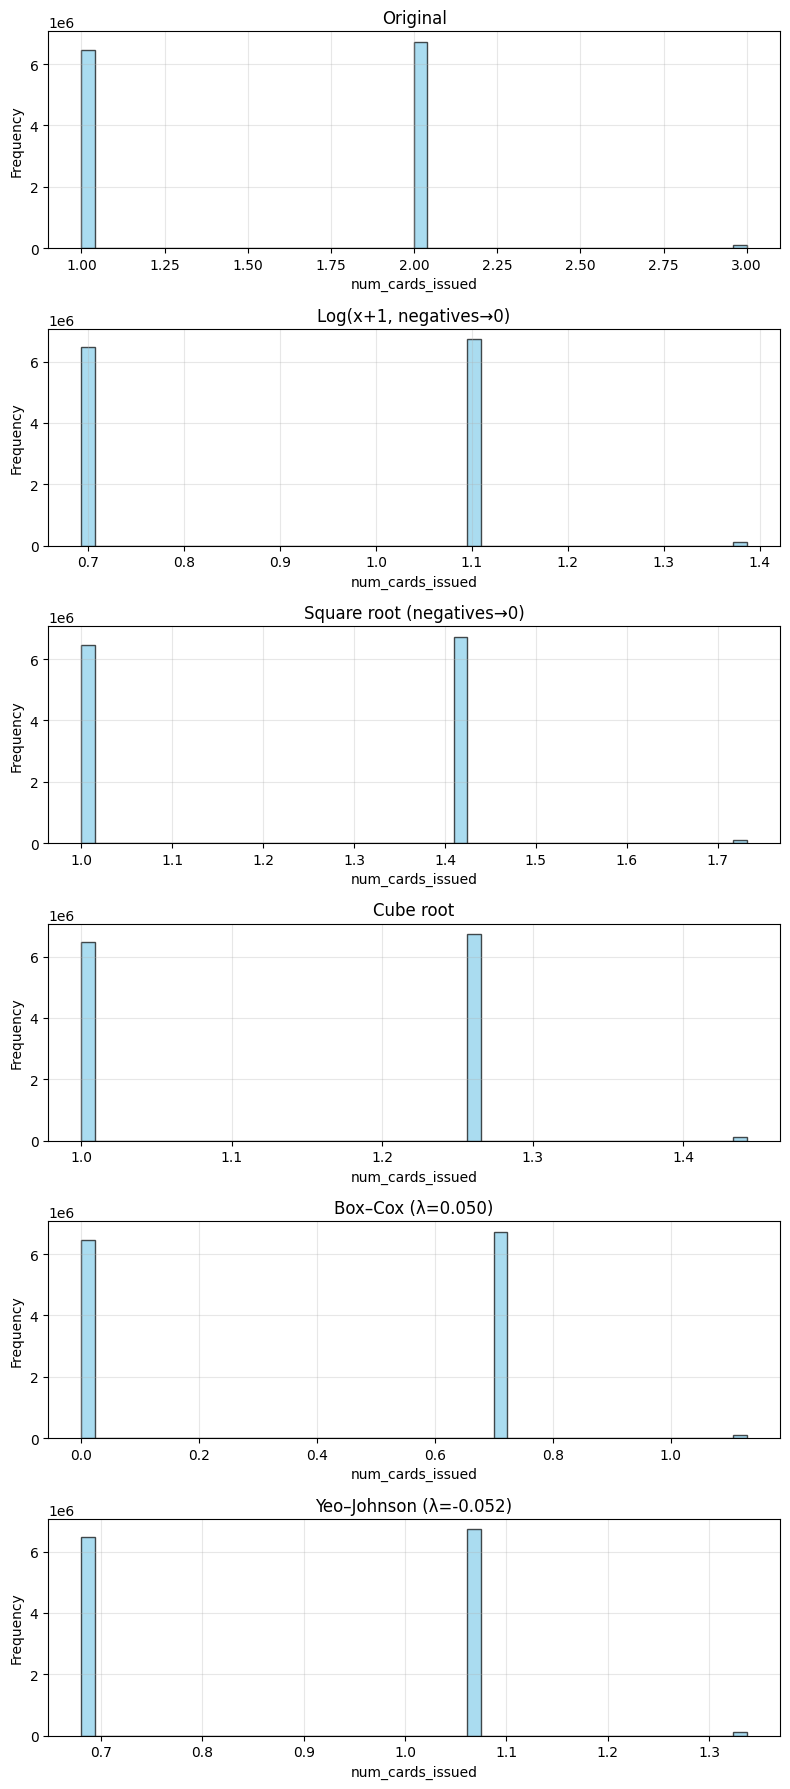

In [ ]:
### 單一變數測試用，查看哪種轉換較佳
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# === 統一設定要分析的欄位名稱 ===
col = "num_cards_issued"

# === 準備資料（不動原始 merged） ===
data = merged[col].copy()

# === 建立結果容器 ===
results = []
transformations = []  # 這個用來存放轉換後的資料，用來畫圖

# === (0) 原始資料 ===
orig_skew = stats.skew(data, bias=False, nan_policy='omit')
orig_kurt = stats.kurtosis(data, bias=False, nan_policy='omit')
results.append(['Original', orig_skew, orig_kurt])
transformations.append(('Original', data))

# === (1) Log 轉換（保留你的原始邏輯）===
log_base = np.where(data < 0, 0, data)
log_trans = np.log(log_base + 1)
results.append([
    'Log(x+1, negatives→0)',
    stats.skew(log_trans, bias=False, nan_policy='omit'),
    stats.kurtosis(log_trans, bias=False, nan_policy='omit')
])
transformations.append(('Log(x+1, negatives→0)', log_trans))

# === (2) 平方根轉換 ===
sqrt_base = np.where(data < 0, 0, data)
sqrt_trans = np.sqrt(sqrt_base)
results.append([
    'Square root (negatives→0)',
    stats.skew(sqrt_trans, bias=False, nan_policy='omit'),
    stats.kurtosis(sqrt_trans, bias=False, nan_policy='omit')
])
transformations.append(('Square root (negatives→0)', sqrt_trans))

# === (3) 立方根轉換 ===
cube_trans = np.cbrt(data)  # 可直接處理負值
results.append([
    'Cube root',
    stats.skew(cube_trans, bias=False, nan_policy='omit'),
    stats.kurtosis(cube_trans, bias=False, nan_policy='omit')
])
transformations.append(('Cube root', cube_trans))

# === (4) Box–Cox 轉換（需全為正值） ===
boxcox_base = np.where(data <= 0, np.nan, data)
if np.all(np.isfinite(boxcox_base)) and np.nanmin(boxcox_base) > 0:
    boxcox_trans, lmbda = stats.boxcox(boxcox_base)
    results.append([
        f'Box–Cox (λ={lmbda:.3f})',
        stats.skew(boxcox_trans, bias=False, nan_policy='omit'),
        stats.kurtosis(boxcox_trans, bias=False, nan_policy='omit')
    ])
    transformations.append((f'Box–Cox (λ={lmbda:.3f})', boxcox_trans))
else:
    results.append(['Box–Cox (skip: nonpositive data)', np.nan, np.nan])

# === (5) Yeo–Johnson 轉換（可處理負值） ===
yj_trans, lmbda_yj = stats.yeojohnson(data)
results.append([
    f'Yeo–Johnson (λ={lmbda_yj:.3f})',
    stats.skew(yj_trans, bias=False, nan_policy='omit'),
    stats.kurtosis(yj_trans, bias=False, nan_policy='omit')
])
transformations.append((f'Yeo–Johnson (λ={lmbda_yj:.3f})', yj_trans))

# === 結果表格 ===
df_results = pd.DataFrame(results, columns=['Transformation', 'Skewness', 'Kurtosis'])
print(df_results)

# === (A) 畫出所有直方圖 ===
n = len(transformations)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 3*n))
plt.subplots_adjust(hspace=0.4)

for i, (title, series) in enumerate(transformations):
    ax = axes[i]
    series = pd.Series(series).dropna()
    ax.hist(series, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(f"{title}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 參數調整參考 
#fig, axes = plt.subplots(1, 2)
#axes[0].hist(data, bins=100)
#axes[1].hist(yj_trans, bins=100)

## age都不建議轉換以保留參數可解釋性

## 04-2_分割訓練集及測試集

In [10]:
#選取數值型變數
num_cols = merged.select_dtypes(include=['int64', 'float64','uint8']).columns
df=merged[num_cols]
#dropna
df_cleaned = df.dropna()
del df
#避免共線性
df_cleaned.drop(columns=["is_fraud_missing_flag","card_type_Debit (Prepaid)", "card_brand_Discover", "use_chip_Online Transaction"], inplace=True)
#分割訓練集及測試集
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=888)

#確認資料分布情形
del df_cleaned, merged
print(train_df['is_fraud'].value_counts(normalize=False))
print(test_df['is_fraud'].value_counts(normalize=False))

is_fraud
0    7121379
1      10591
Name: count, dtype: Int64
is_fraud
0    1780252
1       2741
Name: count, dtype: Int64


## 04-3(a)_Assumption:Linearity of Logit check

📊 解讀圖形
若點呈現大致直線 → 該變數與 logit 關係線性 ✅
若呈現彎曲（U 型、凹凸） → 該變數不線性 ❌
→ 建議對該變數取 log、平方根、或切分分箱再使用

In [16]:
from sklearn.model_selection import train_test_split

#sample_df, _ = train_test_split(
#    train_df,
#    train_size=1,
#    stratify=train_df['is_fraud'],
#    random_state=88
#)

## Box–Tidwell 檢驗
import numpy as np
import pandas as pd
import statsmodels.api as sm

def box_tidwell_test(df, target='is_fraud'):
    """
    自動對連續變數執行 Box–Tidwell 檢驗。
    適用於 Logistic Regression 的 linearity of logit 假設檢查。
    """

    # 1️⃣ 篩出連續變數（排除二元或類別欄位）
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target]
    # 排除只有 0/1 的欄位（常見於 flag）
    continuous_vars = [c for c in numeric_cols if df[c].nunique() > 2]

    print(f"檢測的連續變數共有 {len(continuous_vars)} 個：{continuous_vars}\n")

    results = []

    for var in continuous_vars:
        temp = df[[target, var]].copy()
        # 若有負數或 0，改為 NaN（Box–Tidwell 要求 X > 0）
        temp[var] = np.where(temp[var] <= 0, np.nan, temp[var])
        temp = temp.dropna()

        # 建立交互項 Xi * log(Xi)
        temp[f'{var}_log'] = np.log(temp[var])
        temp[f'{var}_interaction'] = temp[var] * temp[f'{var}_log']

        # Logistic Regression 模型
        X = sm.add_constant(temp[[var, f'{var}_interaction']])
        y = temp[target]

        try:
            model = sm.Logit(y, X).fit(disp=False)
            p_value = model.pvalues.get(f'{var}_interaction', np.nan)
            results.append({
                'Variable': var,
                'p_value': p_value,
                'Linearity': '✅ 線性假設成立' if p_value >= 0.0001 else '❌ 不線性'
            })
        except Exception as e:
            results.append({
                'Variable': var,
                'p_value': np.nan,
                'Linearity': f'⚠️ 模型無法收斂 ({e})'
            })

    results_df = pd.DataFrame(results).sort_values('p_value', na_position='last')
    return results_df

# ✅ 執行檢驗
#train_df["longitude"]=train_df["longitude"]*(-1)
bt_results = box_tidwell_test(train_df, target='is_fraud')

# 查看結果
print("\n=== Box–Tidwell 檢驗結果 ===")
print(bt_results)


檢測的連續變數共有 20 個：['transaction_id', 'client_id_x', 'card_id', 'amount', 'merchant_id', 'zip', 'mcc_code', 'current_age', 'retirement_age', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'card_number', 'cvv', 'num_cards_issued', 'credit_limit']


=== Box–Tidwell 檢驗結果 ===
             Variable        p_value Linearity
3              amount   0.000000e+00     ❌ 不線性
5                 zip  3.951655e-197     ❌ 不線性
6            mcc_code  4.862038e-155     ❌ 不線性
0      transaction_id   2.687609e-49     ❌ 不線性
4         merchant_id   7.491374e-13     ❌ 不線性
7         current_age   8.550089e-11     ❌ 不線性
8      retirement_age   3.006206e-09     ❌ 不線性
16        card_number   5.350365e-05     ❌ 不線性
1         client_id_x   3.156159e-03  ✅ 線性假設成立
18   num_cards_issued   3.498041e-03  ✅ 線性假設成立
9            latitude   8.862748e-03  ✅ 線性假設成立
19       credit_limit   5.781109e-02  ✅ 線性假設成立
14       credit_score   6.754423e-02  ✅ 線性假設成立
15   nu

In [14]:
## 針對longitude模型無法收斂的變數重新檢查

train_df["longitude"]=train_df["longitude"]*(-1)
bt_results = box_tidwell_test(train_df, target='is_fraud')
# 查看結果
print("\n=== Box–Tidwell 檢驗結果(修正longitude) ===")
print(bt_results)
train_df["longitude"]=train_df["longitude"]*(-1)

檢測的連續變數共有 20 個：['transaction_id', 'client_id_x', 'card_id', 'amount', 'merchant_id', 'zip', 'mcc_code', 'current_age', 'retirement_age', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'card_number', 'cvv', 'num_cards_issued', 'credit_limit']


=== Box–Tidwell 檢驗結果(修正longitude) ===
             Variable        p_value Linearity
3              amount   0.000000e+00     ❌ 不線性
5                 zip  3.951655e-197     ❌ 不線性
6            mcc_code  4.862038e-155     ❌ 不線性
0      transaction_id   2.687609e-49     ❌ 不線性
4         merchant_id   7.491374e-13     ❌ 不線性
7         current_age   8.550089e-11     ❌ 不線性
8      retirement_age   3.006206e-09     ❌ 不線性
16        card_number   5.350365e-05     ❌ 不線性
1         client_id_x   3.156159e-03  ✅ 線性假設成立
18   num_cards_issued   3.498041e-03  ✅ 線性假設成立
9            latitude   8.862748e-03  ✅ 線性假設成立
19       credit_limit   5.781109e-02  ✅ 線性假設成立
14       credit_score   6.754423e-02  ✅ 線

In [ ]:
#BY Linearity of Logit check drop 不符合假設的變數 
# ['amount','zip','mcc_code','transaction_id','merchant_id','current_age','retirement_age','card_number']

#bt_results[bt_results["Linearity"] == '❌ 不線性']
nonlinear_vars = bt_results[bt_results["Linearity"] == '❌ 不線性']["Variable"].tolist()
train_df.drop(columns=nonlinear_vars, inplace=True)

## 04-3(b1)_(略04-3(a))Assumption:Avoid Multicollinearity

In [11]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    # 1. 保留數值欄位
    df_num = df.select_dtypes(include=[np.number]).copy()

    # 2. 強制轉成 float64，避免 Int64 / uint8 / object 問題
    df_num = df_num.astype(np.float64)

    # 3. 檢查 inf / NaN
    if not np.isfinite(df_num.values).all():
        raise ValueError("Data contains NaN or infinite values, cannot compute VIF.")

    # 4. 加上截距
    X = sm.add_constant(df_num)

    # 5. 計算 VIF
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) 
                         for i in range(X.shape[1])]

    return vif

# 使用範例
vif_result = calculate_vif(train_df)

/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [12]:
print(vif_result.sort_values(by="VIF Factor", ascending=False))

                       features  VIF Factor
24                  card_number   22.245529
18            per_capita_income   12.893525
19                yearly_income   12.617800
30              card_brand_Amex    4.406311
6                           zip    2.289754
17                    longitude    2.108125
11    use_chip_Chip Transaction    1.747535
12   use_chip_Swipe Transaction    1.714890
27                 credit_limit    1.620728
20                   total_debt    1.529424
9              zip_missing_flag    1.466197
31        card_brand_Mastercard    1.453418
8   merchant_state_missing_flag    1.416254
29              card_type_Debit    1.375570
14                  current_age    1.324877
22             num_credit_cards    1.271952
28             card_type_Credit    1.213829
32              card_brand_Visa    1.039751
2                   client_id_x    1.013492
4                        amount    1.006493
5                   merchant_id    1.005501
13                     is_fraud 

In [13]:
##第一次處理共線性
train_df.drop(columns=["card_number","per_capita_income"], inplace=True)
#再重跑一次VIF

In [14]:
vif_result = calculate_vif(train_df)
print(vif_result.sort_values(by="VIF Factor", ascending=False))
##發現missing_flag的共線性問題，決定保留one hot encoding高vif值的變數

                       features   VIF Factor
0                         const  3105.658128
12   use_chip_Swipe Transaction   569.053663
11    use_chip_Chip Transaction   524.231371
8   merchant_state_missing_flag   250.975101
9              zip_missing_flag    17.249307
29        card_brand_Mastercard    11.382578
30              card_brand_Visa    10.554165
27              card_type_Debit     4.934019
26             card_type_Credit     4.574125
28              card_brand_Amex     3.328285
6                           zip     3.225456
17                    longitude     2.812570
25                 credit_limit     2.115503
18                yearly_income     2.036356
1                transaction_id     1.934434
19                   total_debt     1.579759
14                  current_age     1.400288
21             num_credit_cards     1.324554
31                 has_chip_YES     1.151930
20                 credit_score     1.126756
7                      mcc_code     1.081497
15        

In [15]:
##第2次處理共線性
train_df.drop(columns=["merchant_state_missing_flag","per_capita_income"], inplace=True)
vif_result = calculate_vif(train_df)
print(vif_result.sort_values(by="VIF Factor", ascending=False))

                      features   VIF Factor
0                        const  1018.337627
11  use_chip_Swipe Transaction    38.189398
10   use_chip_Chip Transaction    35.395877
8             zip_missing_flag    16.206919
28       card_brand_Mastercard    11.385527
29             card_brand_Visa    10.556540
26             card_type_Debit     7.130560
25            card_type_Credit     6.035989
27             card_brand_Amex     3.329416
6                          zip     3.226014
16                   longitude     2.812307
24                credit_limit     2.491820
1               transaction_id     1.934437
17               yearly_income     1.783610
18                  total_debt     1.592368
13                 current_age     1.518092
20            num_credit_cards     1.324977
30                has_chip_YES     1.152971
19                credit_score     1.128540
7                     mcc_code     1.081394
14              retirement_age     1.060981
4                       amount  

In [16]:
##第3次處理共線性
train_df.drop(columns=["zip_missing_flag"], inplace=True)
vif_result = calculate_vif(train_df)
print(vif_result.sort_values(by="VIF Factor", ascending=False))

                      features  VIF Factor
0                        const  896.106321
27       card_brand_Mastercard   11.385510
28             card_brand_Visa   10.556537
25             card_type_Debit    7.130470
24            card_type_Credit    6.035986
9    use_chip_Chip Transaction    3.933513
10  use_chip_Swipe Transaction    3.916996
26             card_brand_Amex    3.329412
6                          zip    3.108594
15                   longitude    2.750853
23                credit_limit    2.491754
1               transaction_id    1.934436
16               yearly_income    1.782194
17                  total_debt    1.592355
12                 current_age    1.518029
19            num_credit_cards    1.324968
29                has_chip_YES    1.152920
18                credit_score    1.128527
7                     mcc_code    1.079670
13              retirement_age    1.060980
4                       amount    1.052440
14                    latitude    1.051585
22         

## 04-3(b2)_Assumption:Avoid Multicollinearity

In [ ]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    # 1. 保留數值欄位
    df_num = df.select_dtypes(include=[np.number]).copy()

    # 2. 強制轉成 float64，避免 Int64 / uint8 / object 問題
    df_num = df_num.astype(np.float64)

    # 3. 檢查 inf / NaN
    if not np.isfinite(df_num.values).all():
        raise ValueError("Data contains NaN or infinite values, cannot compute VIF.")

    # 4. 加上截距
    X = sm.add_constant(df_num)

    # 5. 計算 VIF
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) 
                         for i in range(X.shape[1])]

    return vif

# 使用範例
vif_result = calculate_vif(train_df)




                       features   VIF Factor
0                         const  2710.301976
7    use_chip_Swipe Transaction   568.542716
6     use_chip_Chip Transaction   523.621826
3   merchant_state_missing_flag   250.878227
4              zip_missing_flag    16.626807
23        card_brand_Mastercard    11.385142
24              card_brand_Visa    10.553108
12                yearly_income     7.867869
11            per_capita_income     7.663705
21              card_type_Debit     7.306378


In [27]:
print(vif_result.sort_values(by="VIF Factor", ascending=False))

                       features   VIF Factor
0                         const  2710.301976
7    use_chip_Swipe Transaction   568.542716
6     use_chip_Chip Transaction   523.621826
3   merchant_state_missing_flag   250.878227
4              zip_missing_flag    16.626807
23        card_brand_Mastercard    11.385142
24              card_brand_Visa    10.553108
12                yearly_income     7.867869
11            per_capita_income     7.663705
21              card_type_Debit     7.306378
20             card_type_Credit     6.137878
22              card_brand_Amex     3.327756
19                 credit_limit     2.629707
13                   total_debt     1.359297
15             num_credit_cards     1.169906
14                 credit_score     1.090883
25                 has_chip_YES     1.082594
9                      latitude     1.044328
10                    longitude     1.044202
18             num_cards_issued     1.036174
8                      is_fraud     1.018439
2         

In [ ]:
##第2次處理共線性
train_df.drop(columns=["use_chip_Chip Transaction","merchant_state_missing_flag","zip_missing_flag"], inplace=True)
                       
train_df.drop(columns=["card_brand_Visa" ,"card_brand_Amex","card_type_Credit","per_capita_income"], inplace=True)
#再重跑一次VIF


In [21]:
vif_result = calculate_vif(train_df)
print(vif_result.sort_values(by="VIF Factor", ascending=False))
##發現missing_flag的共線性問題

                      features  VIF Factor
0                        const  786.011921
6                          zip    2.532262
14                   longitude    2.461090
15               yearly_income    1.982848
9   use_chip_Swipe Transaction    1.979329
22                credit_limit    1.936067
1               transaction_id    1.769007
16                  total_debt    1.578689
11                 current_age    1.398211
23             card_type_Debit    1.358625
18            num_credit_cards    1.323459
17                credit_score    1.125981
25                has_chip_YES    1.123772
24       card_brand_Mastercard    1.083458
12              retirement_age    1.056872
13                    latitude    1.043536
21            num_cards_issued    1.032646
7                     mcc_code    1.028691
4                       amount    1.028261
2                  client_id_x    1.014898
5                  merchant_id    1.012228
19                 gender_Male    1.010711
3          

In [22]:
import statsmodels.api as sm

# assume train_df is your dataframe and "is_fraud" is the dependent variable
y = train_df["is_fraud"]

# exclude the dependent variable itself
independent_vars = train_df.columns.drop("is_fraud")

results = []

for var in independent_vars:
    X = sm.add_constant(train_df[var])  # add intercept
    model = sm.Logit(y, X)
    try:
        result = model.fit(disp=False)
        coef = result.params[var]
        pval = np.around(result.pvalues[var], 4)
        results.append({"variable": var, "coefficient": coef, "p_value": pval})
    except Exception as e:
        results.append({"variable": var, "coefficient": None, "p_value": None})
        print(f"Skipped {var} due to error: {e}")

# convert to dataframe
summary_df = pd.DataFrame(results)

# optional: sort by p_value
summary_df = summary_df.sort_values("p_value", ascending=True).reset_index(drop=True)

print(summary_df)

                      variable   coefficient  p_value
0                     latitude -8.201997e-03   0.0000
1              card_type_Debit -2.431305e-01   0.0000
2                 credit_limit -1.325726e-05   0.0000
3                       amount  4.194989e-01   0.0000
4                  merchant_id  5.815498e-06   0.0000
5                          zip -5.219329e-05   0.0000
6                     mcc_code -5.383161e-04   0.0000
7          errors_missing_flag -1.034501e+00   0.0000
8   use_chip_Swipe Transaction -2.282721e+00   0.0000
9                  current_age  6.811940e-03   0.0000
10            num_credit_cards  1.108020e-01   0.0000
11                  total_debt -1.507820e-06   0.0000
12               yearly_income -4.518766e-06   0.0000
13                has_chip_YES  1.266255e-01   0.0002
14                credit_score  4.469540e-04   0.0027
15                   longitude -1.721663e-03   0.0035
16                     card_id -1.531231e-05   0.0081
17                 gender_Ma

## 04-4(a)_Forward only model fitting

In [32]:
#Stepwise Selection all variables

def stepwise_logit(train_df, target_col="is_fraud", entry_threshold=0.05):
    # ✅ 確保索引對齊
    train_df = train_df.reset_index(drop=True)
    y = train_df[target_col].reset_index(drop=True)
    
    candidate_vars = list(train_df.columns.drop(target_col))
    included_vars = []
    step_results = []
    
    # Base model (only intercept)
    X_base = sm.add_constant(pd.DataFrame({"intercept": [1]*len(train_df)}))
    base_model = sm.Logit(y, X_base).fit(disp=False)
    base_ll = -2 * base_model.llf
    step_results.append({"Step": 0, "Variable Entered": None, "-2 Log Likelihood": base_ll})
    
    print(f"Step 0: Base model estimated. -2LL = {base_ll:.3f}")
    
    step = 1
    while True:
        best_pval = 1
        best_var = None
        best_model = None
        
        for var in candidate_vars:
            try:
                X_temp = sm.add_constant(train_df[included_vars + [var]])
                model_temp = sm.Logit(y, X_temp).fit(disp=False)
                pval = model_temp.pvalues[var]
                
                if pval < best_pval:
                    best_pval = pval
                    best_var = var
                    best_model = model_temp
                    
            except Exception:
                continue
        
        if best_var is None or best_pval > entry_threshold:
            print("\n✅ No more variables meet the entry threshold. Stepwise selection finished.")
            break
        
        included_vars.append(best_var)
        candidate_vars.remove(best_var)
        
        ll = -2 * best_model.llf
        step_results.append({"Step": step, "Variable Entered": best_var, "-2 Log Likelihood": ll})
        
        print(f"Step {step}: Added {best_var}, p = {best_pval:.4f}, -2LL = {ll:.3f}")
        step += 1
    
    print("\nFinal model summary:")
    print(best_model.summary())
    
    step_df = pd.DataFrame(step_results)
    return step_df, best_model

# 🚀 執行
step_df, final_model = stepwise_logit(train_df, target_col="is_fraud")
step_df


Step 0: Base model estimated. -2LL = 159110.612
Step 1: Added amount, p = 0.0000, -2LL = 156093.371
Step 2: Added zip, p = 0.0000, -2LL = 145021.626
Step 3: Added use_chip_Swipe Transaction, p = 0.0000, -2LL = 138718.303
Step 4: Added transaction_id, p = 0.0000, -2LL = 136604.133
Step 5: Added longitude, p = 0.0000, -2LL = 134022.471
Step 6: Added merchant_id, p = 0.0000, -2LL = 133315.118
Step 7: Added credit_limit, p = 0.0000, -2LL = 132670.051
Step 8: Added num_credit_cards, p = 0.0000, -2LL = 132320.488
Step 9: Added errors_missing_flag, p = 0.0000, -2LL = 132124.144
Step 10: Added mcc_code, p = 0.0000, -2LL = 131949.306
Step 11: Added yearly_income, p = 0.0000, -2LL = 131823.115
Step 12: Added has_chip_YES, p = 0.0000, -2LL = 131725.459
Step 13: Added latitude, p = 0.0000, -2LL = 131645.917
Step 14: Added client_id_x, p = 0.0000, -2LL = 131606.865
Step 15: Added credit_score, p = 0.0000, -2LL = 131582.535
Step 16: Added card_brand_Mastercard, p = 0.0016, -2LL = 131572.543
Step 17:

,Step,Variable Entered,-2 Log Likelihood
0,0,None,159110.612051
1,1,amount,156093.371112
2,2,zip,145021.626191
3,3,use_chip_Swipe Transaction,138718.302823
4,4,transaction_id,136604.133038
5,5,longitude,134022.471436
6,6,merchant_id,133315.118220
7,7,credit_limit,132670.050734
8,8,num_credit_cards,132320.487822
9,9,errors_missing_flag,132124.144311


## 04-4(b)_Forward/Backward v1

In [43]:
## 版本1.0 (含k值控制，但0會有錯誤)
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats

def stepwise_logit_with_k_v1(train_df, test_df, dep_var="is_fraud", k=314657018,
                                 threshold_in=0.05, threshold_out=0.10):
    """
    Stepwise logistic regression (forward + backward) with flexible k control,
    and 3 formatted output tables like table_for_first_step().
    """

    y_train = train_df[dep_var]
    X_train = train_df.drop(columns=[dep_var])
    y_test = test_df[dep_var]
    X_test = test_df.drop(columns=[dep_var])

    included = []
    step = 0
    full_mode = (k == 314657018)
    base_model = None

    while True:
        step += 1
        changed = False

        # ---------- Forward Step ----------
        excluded = list(set(X_train.columns) - set(included))
        new_pvals = pd.Series(index=excluded, dtype=float)
        for new_var in excluded:
            try:
                model = sm.Logit(y_train, sm.add_constant(X_train[included + [new_var]])).fit(disp=False)
                new_pvals[new_var] = model.pvalues[new_var]
            except Exception:
                new_pvals[new_var] = np.nan

        if new_pvals.empty:
            break

        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_var = new_pvals.idxmin()
            included.append(best_var)
            changed = True

        # ---------- Backward Step ----------
        if included:
            model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_var = pvalues.idxmax()
                included.remove(worst_var)
                changed = True

        # ---------- 結束條件 ----------
        if not changed:
            break
        if not full_mode and len(included) >= k:
            break

    # ========= Final Model =========
    final_model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
    ll_full = final_model.llf
    ll_null = sm.Logit(y_train, sm.add_constant(np.ones(len(y_train)))).fit(disp=False).llf

    # 1️⃣ Overall Model Fit
    ll_diff = -2 * (ll_null - ll_full)
    df_diff = len(final_model.params) - 1
    p_value = stats.chi2.sf(ll_diff, df_diff)

    overall_fit = pd.DataFrame({
        "Measure": [
            "-2 Log Likelihood (−2LL) value",
            "Cox and Snell R2",
            "Nagelkerke R2",
            "Pseudo R2 (McFadden)",
            "Hosmer-Lemeshow χ2"
        ],
        "Value": [
            round(-2 * ll_full, 3),
            round(1 - np.exp((2 / len(y_train)) * (ll_null - ll_full)), 3),
            round((1 - np.exp((2 / len(y_train)) * (ll_null - ll_full))) / (1 - np.exp(2 * ll_null / len(y_train))), 3),
            round(1 - (ll_full / ll_null), 3),
            round(ll_diff, 3)
        ],
        "Change_from_Base": [
            round(-2 * (ll_null - ll_full), 3),
            "", "", "", ""
        ],
        "Change_pvalue": [
            round(p_value, 4),
            "", "", "", ""
        ]
    })

    # 2️⃣ Variables in the Equation
    coef_df = pd.DataFrame({
        "Independent Variable": final_model.params.index,
        "B": final_model.params.values,
        "Std. Error": final_model.bse.values,
        "Wald": (final_model.params / final_model.bse) ** 2,
        "df": 1,
        "Sig.": final_model.pvalues.values,
        "Exp(B)": np.exp(final_model.params.values)
    })
    coef_df = coef_df.reset_index(drop=True)

    # 3️⃣ Variables Not in the Equation
    excluded_vars = [v for v in X_train.columns if v not in included]
    not_in_eq = []
    for var in excluded_vars:
        try:
            temp_model = sm.Logit(y_train, sm.add_constant(X_train[included + [var]])).fit(disp=False)
            lr_stat = -2 * (final_model.llf - temp_model.llf)
            p_val = stats.chi2.sf(lr_stat, 1)
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": round(lr_stat, 3),
                              "Significance": round(p_val, 4)})
        except Exception:
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": None,
                              "Significance": None})

    not_in_eq_df = pd.DataFrame(not_in_eq)

    # 額外：Train / Test Accuracy
    train_pred = (final_model.predict(sm.add_constant(X_train[included])) > 0.5).astype(int)
    test_pred = (final_model.predict(sm.add_constant(X_test[included])) > 0.5).astype(int)
    train_acc = (train_pred == y_train).mean()
    test_acc = (test_pred == y_test).mean()

    print(f"\n✅ Stepwise completed with {len(included)} variables: {included}")
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    return overall_fit, coef_df, not_in_eq_df, final_model



from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.5):
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
    })
    return table


In [44]:
## 版本1.0用法 k=1
overall_fit, coef_df, not_in_eq_df, model1_0 = stepwise_logit_with_k_v1(
    train_df, test_df, dep_var="is_fraud", k=0
)

print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")



# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model1_0, train_df, target_col="is_fraud")
test_table = classification_table(model1_0, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))



✅ Stepwise completed with 1 variables: ['use_chip_Swipe Transaction']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  150529.771         8580.841           0.0
1                Cox and Snell R2       0.001                               
2                   Nagelkerke R2       0.055                               
3            Pseudo R2 (McFadden)       0.054                               
4              Hosmer-Lemeshow χ2    8580.841                               

=== Variables in the Equation ===
         Independent Variable         B  Std. Error           Wald  df  Sig.  \
0                       const -5.874597    0.010263  327657.488906   1   0.0   
1  use_chip_Swipe Transaction -2.282721    0.032252    5009.563547   1   0.0   

     Exp(B)  
0  0.002810  
1  0.102006  

=== Variables Not in the Equation ===
         Independent Variable  Score S

In [46]:
## 版本1.0用法 k=2
overall_fit, coef_df, not_in_eq_df, model1_2 = stepwise_logit_with_k_v1(
    train_df, test_df, dep_var="is_fraud", k=2
)

print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")



# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model1_2, train_df, target_col="is_fraud")
test_table = classification_table(model1_2, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))



✅ Stepwise completed with 2 variables: ['use_chip_Swipe Transaction', 'use_chip_Chip Transaction']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  140489.383        18621.229           0.0
1                Cox and Snell R2       0.003                               
2                   Nagelkerke R2       0.118                               
3            Pseudo R2 (McFadden)       0.117                               
4              Hosmer-Lemeshow χ2   18621.229                               

=== Variables in the Equation ===
         Independent Variable         B  Std. Error           Wald  df  Sig.  \
0                       const -4.775196    0.012014  157988.198965   1   0.0   
1  use_chip_Swipe Transaction -3.382122    0.032851   10599.503435   1   0.0   
2   use_chip_Chip Transaction -2.142826    0.023224    8513.341264   1   0.0   

     Exp(B

In [47]:
## 版本1.0用法 k=3
overall_fit, coef_df, not_in_eq_df, model1_3 = stepwise_logit_with_k_v1(
    train_df, test_df, dep_var="is_fraud", k=3
)

print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")



# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model1_3, train_df, target_col="is_fraud")
test_table = classification_table(model1_3, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))



✅ Stepwise completed with 3 variables: ['use_chip_Swipe Transaction', 'use_chip_Chip Transaction', 'num_credit_cards']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  140105.114        19005.498           0.0
1                Cox and Snell R2       0.003                               
2                   Nagelkerke R2       0.121                               
3            Pseudo R2 (McFadden)       0.119                               
4              Hosmer-Lemeshow χ2   19005.498                               

=== Variables in the Equation ===
         Independent Variable         B  Std. Error          Wald  df  \
0                       const -5.233481    0.026969  37656.509502   1   
1  use_chip_Swipe Transaction -3.387820    0.032852  10634.301908   1   
2   use_chip_Chip Transaction -2.144975    0.023225   8529.465073   1   
3            num_cr

In [48]:
## 版本1.0用法 k=4
overall_fit, coef_df, not_in_eq_df, model1_4 = stepwise_logit_with_k_v1(
    train_df, test_df, dep_var="is_fraud", k=4
)

print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")



# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model1_4, train_df, target_col="is_fraud")
test_table = classification_table(model1_4, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))



✅ Stepwise completed with 4 variables: ['use_chip_Swipe Transaction', 'use_chip_Chip Transaction', 'num_credit_cards', 'credit_limit']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  139677.397        19433.215           0.0
1                Cox and Snell R2       0.003                               
2                   Nagelkerke R2       0.123                               
3            Pseudo R2 (McFadden)       0.122                               
4              Hosmer-Lemeshow χ2   19433.215                               

=== Variables in the Equation ===
         Independent Variable         B  Std. Error          Wald  df  \
0                       const -4.827954    0.032721  21770.702363   1   
1  use_chip_Swipe Transaction -3.399624    0.032858  10705.083395   1   
2   use_chip_Chip Transaction -2.154422    0.023231   8600.907305   1   
3  

In [ ]:
## 版本1.0用法 k=1
overall_fit, coef_df, not_in_eq_df, model1_all = stepwise_logit_with_k_v1(
    train_df, test_df, dep_var="is_fraud", k=314657018
)

print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")



# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model1_all, train_df, target_col="is_fraud")
test_table = classification_table(model1_all, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


## 04-4(c)_Forward/Backward v2

In [23]:
## 版本2.0: 修正k=0，並加入即時追蹤
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats

def stepwise_logit_with_k_tables(train_df, test_df, dep_var="is_fraud", k=314657018,
                                 threshold_in=0.05, threshold_out=0.10, verbose=True):
    """
    Stepwise logistic regression (forward + backward) with flexible k control,
    and 3 formatted output tables like table_for_first_step().
    """

    y_train = train_df[dep_var]
    X_train = train_df.drop(columns=[dep_var])
    y_test = test_df[dep_var]
    X_test = test_df.drop(columns=[dep_var])

    included = []
    step = 0
    full_mode = (k == 314657018)

    # ========= 🔸 特殊情況：k = 0，只跑 intercept =========
    if k == 0:
        final_model = sm.Logit(y_train, sm.add_constant(np.ones(len(y_train)))).fit(disp=False)
        ll_full = final_model.llf
        ll_null = ll_full

        overall_fit = pd.DataFrame({
            "Measure": ["-2 Log Likelihood (−2LL) value"],
            "Value": [round(-2 * ll_full, 3)],
            "Change_from_Base": [""],
            "Change_pvalue": [""]
        })

        coef_df = pd.DataFrame({
            "Independent Variable": ["const"],
            "B": final_model.params.values,
            "Std. Error": final_model.bse.values,
            "Wald": [np.nan],
            "df": [1],
            "Sig.": [""],
            "Exp(B)": np.exp(final_model.params.values)
        })

        not_in_eq_df = pd.DataFrame({
            "Independent Variable": X_train.columns,
            "Score Statistic (LRT)": [None]*len(X_train.columns),
            "Significance": [None]*len(X_train.columns)
        })

        print(f"\n✅ Stepwise completed with 0 variables (Intercept only).")
        return overall_fit, coef_df, not_in_eq_df, final_model
    # ======================================================

    # ---------- Regular Stepwise ----------
    while True:
        step += 1
        changed = False

        # ---------- Forward Step ----------
        excluded = list(set(X_train.columns) - set(included))
        new_pvals = pd.Series(index=excluded, dtype=float)
        for new_var in excluded:
            try:
                model = sm.Logit(y_train, sm.add_constant(X_train[included + [new_var]])).fit(disp=False)
                new_pvals[new_var] = model.pvalues[new_var]
            except Exception:
                new_pvals[new_var] = np.nan

        if new_pvals.empty:
            break

        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_var = new_pvals.idxmin()
            included.append(best_var)
            changed = True
            if verbose:
                print(f"🟢 Step {step}: Forward — added variable: {best_var} (p={best_pval:.4g})")

        # ---------- Backward Step ----------
        if included:
            model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
            pvalues = model.pvalues.iloc[1:]  # skip intercept
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_var = pvalues.idxmax()
                included.remove(worst_var)
                changed = True
                if verbose:
                    print(f"🔴 Step {step}: Backward — removed variable: {worst_var} (p={worst_pval:.4g})")

        # ---------- 結束條件 ----------
        if not changed:
            if verbose:
                print(f"⚪ Step {step}: No change — stopping iteration.")
            break
        if not full_mode and len(included) >= k:
            if verbose:
                print(f"🟡 Reached k={k}, stopping after {len(included)} variables.")
            break

    # ========= Final Model =========
    final_model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
    ll_full = final_model.llf
    ll_null = sm.Logit(y_train, sm.add_constant(np.ones(len(y_train)))).fit(disp=False).llf

    # 1️⃣ Overall Model Fit
    ll_diff = -2 * (ll_null - ll_full)
    df_diff = len(final_model.params) - 1
    p_value = stats.chi2.sf(ll_diff, df_diff)

    overall_fit = pd.DataFrame({
        "Measure": [
            "-2 Log Likelihood (−2LL) value",
            "Cox and Snell R2",
            "Nagelkerke R2",
            "Pseudo R2 (McFadden)",
            "Hosmer-Lemeshow χ2"
        ],
        "Value": [
            round(-2 * ll_full, 3),
            round(1 - np.exp((2 / len(y_train)) * (ll_null - ll_full)), 3),
            round((1 - np.exp((2 / len(y_train)) * (ll_null - ll_full))) / (1 - np.exp(2 * ll_null / len(y_train))), 3),
            round(1 - (ll_full / ll_null), 3),
            round(ll_diff, 3)
        ],
        "Change_from_Base": [
            round(-2 * (ll_null - ll_full), 3),
            "", "", "", ""
        ],
        "Change_pvalue": [
            round(p_value, 4),
            "", "", "", ""
        ]
    })

    # 2️⃣ Variables in the Equation
    coef_df = pd.DataFrame({
        "Independent Variable": final_model.params.index,
        "B": final_model.params.values,
        "Std. Error": final_model.bse.values,
        "Wald": (final_model.params / final_model.bse) ** 2,
        "df": 1,
        "Sig.": final_model.pvalues.values,
        "Exp(B)": np.exp(final_model.params.values)
    })
    coef_df = coef_df.reset_index(drop=True)

    # 3️⃣ Variables Not in the Equation
    excluded_vars = [v for v in X_train.columns if v not in included]
    not_in_eq = []
    for var in excluded_vars:
        try:
            temp_model = sm.Logit(y_train, sm.add_constant(X_train[included + [var]])).fit(disp=False)
            lr_stat = -2 * (final_model.llf - temp_model.llf)
            p_val = stats.chi2.sf(lr_stat, 1)
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": round(lr_stat, 3),
                              "Significance": round(p_val, 4)})
        except Exception:
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": None,
                              "Significance": None})

    not_in_eq_df = pd.DataFrame(not_in_eq)

    # 額外：Train / Test Accuracy
    train_pred = (final_model.predict(sm.add_constant(X_train[included])) > 0.5).astype(int)
    test_pred = (final_model.predict(sm.add_constant(X_test[included])) > 0.5).astype(int)
    train_acc = (train_pred == y_train).mean()
    test_acc = (test_pred == y_test).mean()

    print(f"\n✅ Stepwise completed with {len(included)} variables: {included}")
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    return overall_fit, coef_df, not_in_eq_df, final_model

from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.5):
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
    })
    return table


In [24]:
## 版本2.0用法 k=1

overall_fit, coef_df, not_in_eq_df, model_0 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=1, verbose=True
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")



# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_0, train_df, target_col="is_fraud")
test_table = classification_table(model_0, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


🟢 Step 1: Forward — added variable: amount (p=0)
🟡 Reached k=1, stopping after 1 variables.

✅ Stepwise completed with 1 variables: ['amount']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  156093.371         3017.241           0.0
1                Cox and Snell R2       0.000                               
2                   Nagelkerke R2       0.019                               
3            Pseudo R2 (McFadden)       0.019                               
4              Hosmer-Lemeshow χ2    3017.241                               

=== Variables in the Equation ===
  Independent Variable         B  Std. Error          Wald  df  Sig.    Exp(B)
0                const -7.969281    0.032682  59459.216608   1   0.0  0.000346
1               amount  0.419499    0.008177   2631.865503   1   0.0  1.521199

=== Variables Not in the Equation ===
          In

In [25]:
## 版本2.0 k=2
#overall_fit, coef_df, not_in_eq_df, model_2 = stepwise_logit_with_k_tables(
#    train_df, test_df, dep_var="is_fraud", k=0
#)

overall_fit, coef_df, not_in_eq_df, model_2 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=2, verbose=True
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")


# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_2, train_df, target_col="is_fraud")
test_table = classification_table(model_2, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


🟢 Step 1: Forward — added variable: amount (p=0)
🟢 Step 2: Forward — added variable: use_chip_Swipe Transaction (p=0)
🟡 Reached k=2, stopping after 2 variables.

✅ Stepwise completed with 2 variables: ['amount', 'use_chip_Swipe Transaction']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  147825.886        11284.726           0.0
1                Cox and Snell R2       0.002                               
2                   Nagelkerke R2       0.072                               
3            Pseudo R2 (McFadden)       0.071                               
4              Hosmer-Lemeshow χ2   11284.726                               

=== Variables in the Equation ===
         Independent Variable         B  Std. Error          Wald  df  Sig.  \
0                       const -7.302016    0.033401  47792.913754   1   0.0   
1                      amount  

In [26]:
## 版本2.0用法 k=3
#overall_fit, coef_df, not_in_eq_df, model_3 = stepwise_logit_with_k_tables(
#    train_df, test_df, dep_var="is_fraud", k=0
#)

overall_fit, coef_df, not_in_eq_df, model_3 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=3, verbose=True
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")


# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_3, train_df, target_col="is_fraud")
test_table = classification_table(model_3, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


🟢 Step 1: Forward — added variable: amount (p=0)
🟢 Step 2: Forward — added variable: use_chip_Swipe Transaction (p=0)
🟢 Step 3: Forward — added variable: zip (p=0)
🟡 Reached k=3, stopping after 3 variables.

✅ Stepwise completed with 3 variables: ['amount', 'use_chip_Swipe Transaction', 'zip']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  138718.303        20392.309           0.0
1                Cox and Snell R2       0.003                               
2                   Nagelkerke R2       0.129                               
3            Pseudo R2 (McFadden)       0.128                               
4              Hosmer-Lemeshow χ2   20392.309                               

=== Variables in the Equation ===
         Independent Variable         B    Std. Error          Wald  df  Sig.  \
0                       const -5.727502  3.741483e-02  

In [27]:
## 版本2.0 k=4

overall_fit, coef_df, not_in_eq_df, model_4 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=4, verbose=True
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_4, train_df, target_col="is_fraud")
test_table = classification_table(model_4, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


🟢 Step 1: Forward — added variable: amount (p=0)
🟢 Step 2: Forward — added variable: use_chip_Swipe Transaction (p=0)
🟢 Step 3: Forward — added variable: zip (p=0)
🟢 Step 4: Forward — added variable: longitude (p=0)
🟡 Reached k=4, stopping after 4 variables.

✅ Stepwise completed with 4 variables: ['amount', 'use_chip_Swipe Transaction', 'zip', 'longitude']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  135185.504        23925.108           0.0
1                Cox and Snell R2       0.003                               
2                   Nagelkerke R2       0.152                               
3            Pseudo R2 (McFadden)       0.150                               
4              Hosmer-Lemeshow χ2   23925.108                               

=== Variables in the Equation ===
         Independent Variable         B    Std. Error          Wald  df

In [28]:
## 版本2.0 k=314657018 (Full Model)

overall_fit, coef_df, not_in_eq_df, final_model = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=314657018, verbose=True
)

print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(final_model, train_df, target_col="is_fraud")
test_table = classification_table(final_model, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


🟢 Step 1: Forward — added variable: amount (p=0)
🟢 Step 2: Forward — added variable: use_chip_Swipe Transaction (p=0)
🟢 Step 3: Forward — added variable: zip (p=0)
🟢 Step 4: Forward — added variable: longitude (p=0)
🟢 Step 5: Forward — added variable: transaction_id (p=1.036e-260)
🟢 Step 6: Forward — added variable: merchant_id (p=8.511e-158)
🟢 Step 7: Forward — added variable: credit_limit (p=3.368e-124)
🟢 Step 8: Forward — added variable: num_credit_cards (p=4.218e-79)
🟢 Step 9: Forward — added variable: errors_missing_flag (p=1.227e-54)
🟢 Step 10: Forward — added variable: mcc_code (p=1.396e-37)
🟢 Step 11: Forward — added variable: yearly_income (p=3.664e-27)
🟢 Step 12: Forward — added variable: has_chip_YES (p=4.869e-25)
🟢 Step 13: Forward — added variable: latitude (p=3.751e-19)
🟢 Step 14: Forward — added variable: client_id_x (p=3.934e-10)
🟢 Step 15: Forward — added variable: credit_score (p=8.597e-07)
🟢 Step 16: Forward — added variable: card_brand_Mastercard (p=0.001582)
🟢 Step

In [29]:
## 一些模型檢驗診斷
def cutoff_analysis(model, df, target_col="is_fraud", cutoffs=None):
    """
    產出類似 Table 8.7 的結果
    """
    if cutoffs is None:
        cutoffs = np.arange(0, 1.01, 0.02)  # 預設 0, 0.02, ..., 1
    
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_prob = model.predict(X)

    rows = []
    for cutoff in cutoffs:
        y_pred = (y_prob >= cutoff).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # 注意順序 [0,1]
        TN, FP, FN, TP = cm.ravel()

        total = TP + TN + FP + FN
        accuracy = (TP + TN) / total if total > 0 else np.nan
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        youden = sensitivity + specificity - 1 if not np.isnan(sensitivity) and not np.isnan(specificity) else np.nan
        ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        npv = TN / (TN + FN) if (TN + FN) > 0 else np.nan

        rows.append({
            "Cutoff": cutoff,
            "TN": TN, "FP": FP, "FN": FN, "TP": TP,
            "Accuracy": round(accuracy*100, 1),
            "Sensitivity": round(sensitivity*100, 1) if not np.isnan(sensitivity) else "NC",
            "Specificity": round(specificity*100, 1) if not np.isnan(specificity) else "NC",
            "Youden": round(youden*100, 1) if not np.isnan(youden) else "NC",
            "PPV": round(ppv*100, 1) if not np.isnan(ppv) else "NC",
            "NPV": round(npv*100, 1) if not np.isnan(npv) else "NC",
        })

    return pd.DataFrame(rows)

cutoff_table_all = cutoff_analysis(final_model, test_df, target_col="is_fraud",
                               cutoffs=[0,0.1,0.2,0.3,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,0.6,0.7,0.8,0.9,1])

print(cutoff_table_all.to_string(index=False))



 Cutoff      TN      FP   FN   TP  Accuracy  Sensitivity  Specificity  Youden  PPV   NPV
   0.00       0 1780252    0 2741       0.2        100.0          0.0     0.0  0.2    NC
   0.10 1780134     118 2735    6      99.8          0.2        100.0     0.2  4.8  99.8
   0.20 1780247       5 2741    0      99.8          0.0        100.0    -0.0  0.0  99.8
   0.30 1780251       1 2741    0      99.8          0.0        100.0    -0.0  0.0  99.8
   0.40 1780252       0 2741    0      99.8          0.0        100.0     0.0   NC  99.8
   0.42 1780252       0 2741    0      99.8          0.0        100.0     0.0   NC  99.8
   0.44 1780252       0 2741    0      99.8          0.0        100.0     0.0   NC  99.8
   0.46 1780252       0 2741    0      99.8          0.0        100.0     0.0   NC  99.8
   0.48 1780252       0 2741    0      99.8          0.0        100.0     0.0   NC  99.8
   0.50 1780252       0 2741    0      99.8          0.0        100.0     0.0   NC  99.8
   0.52 1780252      

In [30]:
cutoffs_v1 = [round(x, 4) for x in np.arange(0, 0.11, 0.0005)]  # 0 ~ 0.2 間隔 0.02
cutoffs_v1 += [round(x, 4) for x in np.arange(0.2, 1.01, 0.1)]  # 0.3 ~ 1 間隔 0.1

cutoff_table_zoom = cutoff_analysis(final_model, test_df, target_col="is_fraud", cutoffs=cutoffs_v1)
print(cutoff_table_zoom.to_string(index=False))

 Cutoff      TN      FP   FN   TP  Accuracy  Sensitivity  Specificity  Youden  PPV    NPV
 0.0000       0 1780252    0 2741       0.2        100.0          0.0     0.0  0.2     NC
 0.0005 1104671  675581  208 2533      62.1         92.4         62.1    54.5  0.4  100.0
 0.0010 1289648  490604  299 2442      72.5         89.1         72.4    61.5  0.5  100.0
 0.0015 1382546  397706  394 2347      77.7         85.6         77.7    63.3  0.6  100.0
 0.0020 1447490  332762  488 2253      81.3         82.2         81.3    63.5  0.7  100.0
 0.0025 1497197  283055  573 2168      84.1         79.1         84.1    63.2  0.8  100.0
 0.0030 1537646  242606  687 2054      86.4         74.9         86.4    61.3  0.8  100.0
 0.0035 1570366  209886  784 1957      88.2         71.4         88.2    59.6  0.9  100.0
 0.0040 1597370  182882  871 1870      89.7         68.2         89.7    58.0  1.0   99.9
 0.0045 1619422  160830  961 1780      90.9         64.9         91.0    55.9  1.1   99.9
 0.0050 16

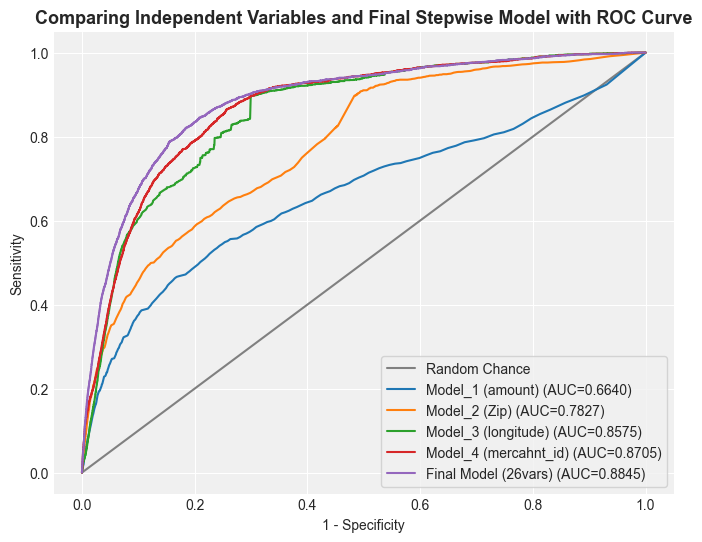

AUC values:
Model_1 (amount): 0.6640
Model_2 (Zip): 0.7827
Model_3 (longitude): 0.8575
Model_4 (mercahnt_id): 0.8705
Final Model (26vars): 0.8845


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


def plot_multiple_roc(models, model_names, test_df, target_col="is_fraud"):
    """
    models: list of fitted statsmodels.Logit models
    model_names: list of strings
    test_df: test dataframe
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    # 隨機機率線
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Random Chance')

    auc_values = {}

    for model, name in zip(models, model_names):
        # 取出模型變數
        vars_used = model.params.index.drop("const")
        X_test = sm.add_constant(test_df[vars_used])

        # 計算預測機率
        y_true = test_df[target_col]
        y_score = model.predict(X_test)

        # ROC 曲線
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        auc_values[name] = auc_val

        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.4f})")

    plt.title("Comparing Independent Variables and Final Stepwise Model with ROC Curve", fontsize=13, fontweight='bold')
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.legend(loc="lower right", frameon=True)
    plt.show()

    # 印出 AUC summary
    print("AUC values:")
    for name, val in auc_values.items():
        print(f"{name}: {val:.4f}")

# 假設你已經有以下模型：
# model_1 = sm.Logit(y_train, sm.add_constant(X_train[["X13"]])).fit(disp=False)
# model_2 = sm.Logit(y_train, sm.add_constant(X_train[["X17"]])).fit(disp=False)
# final_model = ...

# 範例呼叫
plot_multiple_roc(
    models=[model_0, model_2, model_3,model_4, final_model],
    model_names=["Model_1 (amount)", "Model_2 (Zip)", "Model_3 (longitude)","Model_4 (mercahnt_id)", "Final Model (26vars)"],
    test_df=test_df,
    target_col="is_fraud"
)


## 04-4(d) 對照圖 amount 取log only

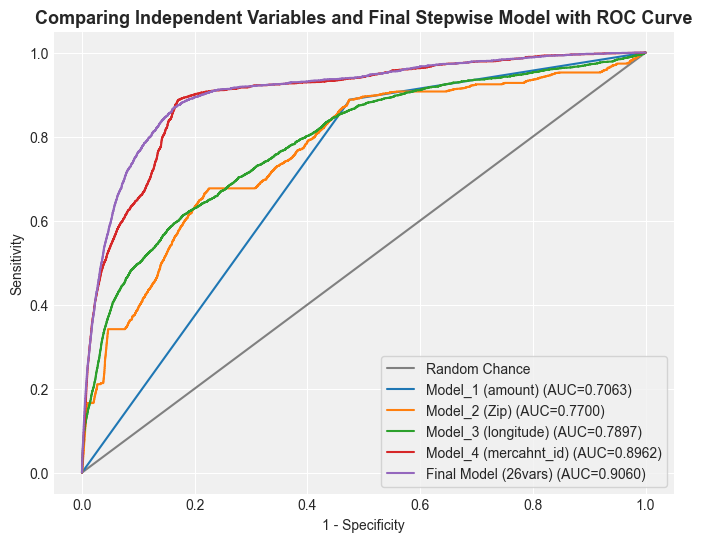

AUC values:
Model_1 (amount): 0.7063
Model_2 (Zip): 0.7700
Model_3 (longitude): 0.7897
Model_4 (mercahnt_id): 0.8962
Final Model (26vars): 0.9060


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_multiple_roc(models, model_names, test_df, target_col="is_fraud"):
    """
    models: list of fitted statsmodels.Logit models
    model_names: list of strings
    test_df: test dataframe
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    # 隨機機率線
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Random Chance')

    auc_values = {}

    for model, name in zip(models, model_names):
        # 取出模型變數
        vars_used = model.params.index.drop("const")
        X_test = sm.add_constant(test_df[vars_used])

        # 計算預測機率
        y_true = test_df[target_col]
        y_score = model.predict(X_test)

        # ROC 曲線
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        auc_values[name] = auc_val

        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.4f})")

    plt.title("Comparing Independent Variables and Final Stepwise Model with ROC Curve", fontsize=13, fontweight='bold')
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.legend(loc="lower right", frameon=True)
    plt.show()

    # 印出 AUC summary
    print("AUC values:")
    for name, val in auc_values.items():
        print(f"{name}: {val:.4f}")

# 假設你已經有以下模型：
# model_1 = sm.Logit(y_train, sm.add_constant(X_train[["X13"]])).fit(disp=False)
# model_2 = sm.Logit(y_train, sm.add_constant(X_train[["X17"]])).fit(disp=False)
# final_model = ...

# 範例呼叫
plot_multiple_roc(
    models=[model_0, model_2, model_3, model_4, final_model],
    model_names=["Model_1 (amount)", "Model_2 (Zip)", "Model_3 (longitude)","Model_4 (mercahnt_id)", "Final Model (26vars)"],
    test_df=test_df,
    target_col="is_fraud"
)


## 04-5(a)_ Model BY SkLEARN

In [33]:
included=['amount', 'use_chip_Swipe Transaction', 'zip', 'longitude', 'transaction_id', 'merchant_id', 'credit_limit', 'num_credit_cards', 'errors_missing_flag', 'mcc_code', 'yearly_income', 'has_chip_YES', 'latitude', 'client_id_x', 'credit_score', 'card_brand_Mastercard', 'retirement_age', 'card_id']
#['amount', 'use_chip_Swipe Transaction', 'transaction_id', 'zip', 'longitude', 'use_chip_Chip Transaction', 'merchant_id', 'credit_limit', 'num_credit_cards', 'errors_missing_flag', 'yearly_income', 'client_id_x', 'latitude', 'mcc_code', 'has_chip_YES', 'credit_score', 'card_type_Credit', 'retirement_age', 'card_type_Debit', 'total_debt', 'card_brand_Visa']
#['use_chip_Swipe Transaction', 'use_chip_Chip Transaction', 'num_credit_cards', 'credit_limit', 'errors_missing_flag', 'per_capita_income', 'has_chip_YES', 'client_id_x', 'card_type_Debit', 'card_id', 'longitude', 'latitude']

In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.stats import chi2


def _compute_cov_and_se(model, X_scaled):
    """
    根據已訓練的 sklearn LogisticRegression model 與已 scale 過的 X，
    使用 observed Fisher information matrix 計算共變異數矩陣與標準誤。
    回傳 (cov_matrix, se_array)；se_array 包含 intercept 的 se 在 index 0。
    """
    n = X_scaled.shape[0]
    X_design = np.hstack([np.ones((n, 1)), X_scaled])  # 加上截距欄
    p = model.predict_proba(X_scaled)[:, 1]
    W = p * (1 - p)
    XtWX = X_design.T @ (W[:, None] * X_design)

    try:
        cov = np.linalg.inv(XtWX)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(XtWX)

    se = np.sqrt(np.maximum(np.diag(cov), 0.0))
    return cov, se


def compute_not_in_eq(y_train, X_train, included, excluded_vars):
    """
    對每一個 excluded variable 做單變量 logistic（含 intercept）並計算 Wald & p-value。
    回傳 DataFrame，欄位: Independent Variable, Wald, Sig.
    """
    results = []
    for var in excluded_vars:
        try:
            X_var = X_train[[var]].astype(float)
            scaler = StandardScaler()
            X_var_scaled = scaler.fit_transform(X_var)

            model = LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=1000)
            model.fit(X_var_scaled, y_train)

            coef = model.coef_[0][0]
            cov, se = _compute_cov_and_se(model, X_var_scaled)
            se_var = se[1] if len(se) > 1 else np.nan

            if se_var == 0 or np.isnan(se_var):
                wald = np.nan
                pval = np.nan
            else:
                wald = (coef / se_var) ** 2
                pval = float(chi2.sf(wald, df=1))

            results.append({
                "Independent Variable": var,
                "Wald": round(float(wald), 3) if not np.isnan(wald) else None,
                "Sig.": round(float(pval), 4) if not np.isnan(pval) else None
            })
        except Exception:
            results.append({
                "Independent Variable": var,
                "Wald": None,
                "Sig.": None
            })
    return pd.DataFrame(results)


def sklearn_logit_with_k(train_df, test_df, dep_var, included, k=314657018):
    """
    仿 SPSS/Statmodels 輸出格式的 sklearn logistic regression（含 intercept, Std.Error, Wald, Sig）
    回傳: overall_fit, coef_df, not_in_eq_df, model, scaler
    """
    # === 1. 準備資料 ===
    y_train = train_df[dep_var].astype(int).values
    y_test = test_df[dep_var].astype(int).values

    if k == 314657018:
        selected_vars = included
    else:
        selected_vars = included[:k]

    X_train = train_df[selected_vars].astype(float).copy()
    X_test = test_df[selected_vars].astype(float).copy()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # === 2. 建立模型 ===
    model = LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=2000)
    model.fit(X_train_scaled, y_train)

    # === 3. 模型擬合度 ===
    base_ll = log_loss(y_train, np.full_like(y_train, y_train.mean(), dtype=float), normalize=False)
    full_ll = log_loss(y_train, model.predict_proba(X_train_scaled)[:, 1], normalize=False)
    llr = base_ll - full_ll
    n = len(y_train)

    r2_cox_snell = 1 - np.exp(-(2.0 / n) * llr)
    denom = 1 - np.exp((-2.0 / n) * base_ll)
    r2_nagelkerke = r2_cox_snell / denom if denom != 0 else np.nan
    r2_mcfadden = 1 - (full_ll / base_ll) if base_ll != 0 else np.nan

    LR_chi2 = 2.0 * llr
    LR_df = len(selected_vars)
    LR_pvalue = float(chi2.sf(LR_chi2, df=LR_df))

    overall_fit = pd.DataFrame({
        "Measure": [
            "-2 Log Likelihood (−2LL) value",
            "Cox and Snell R2",
            "Nagelkerke R2",
            "Pseudo R2 (McFadden)",
            "Likelihood Ratio χ2",
        ],
        "Value": [
            round(2.0 * full_ll, 3),
            round(r2_cox_snell, 3),
            round(r2_nagelkerke, 3),
            round(r2_mcfadden, 3),
            round(LR_chi2, 3)
        ],
        "Change_from_Base": [round(LR_chi2, 3), "", "", "", ""],
        "Change_pvalue": [round(LR_pvalue, 6), "", "", "", ""]
    })

    # === 4. 變數係數表（含 intercept）===
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    cov, se_all = _compute_cov_and_se(model, X_train_scaled)
    se_beta = se_all[1:]  # predictors
    se_intercept = se_all[0]

    # 計算 Wald 與 p 值
    wald_vals, pvals = [], []
    for b, se in zip(coef, se_beta):
        if se == 0 or np.isnan(se):
            wald_vals.append(np.nan)
            pvals.append(np.nan)
        else:
            w = (b / se) ** 2
            wald_vals.append(w)
            pvals.append(float(chi2.sf(w, df=1)))

    intercept_wald = (intercept / se_intercept) ** 2 if se_intercept != 0 else np.nan
    intercept_pval = float(chi2.sf(intercept_wald, df=1)) if not np.isnan(intercept_wald) else np.nan

    coef_df = pd.DataFrame({
        "Independent Variable": ["(Intercept)"] + selected_vars,
        "B": np.round([intercept] + coef.tolist(), 6),
        "Std. Error": [round(float(x), 6) for x in se_all],
        "Wald": [round(float(intercept_wald), 3)] +
                [round(float(x), 3) if not np.isnan(x) else None for x in wald_vals],
        "df": [1] * (len(coef) + 1),
        "Sig.": [round(float(intercept_pval), 6)] +
                [round(float(x), 6) if not np.isnan(x) else None for x in pvals],
        "Exp(B)": np.round(np.exp([intercept] + coef.tolist()), 6)
    })

    # === 5. Variables not in Equation ===
    excluded_vars = [v for v in included if v not in selected_vars]
    not_in_eq_df = compute_not_in_eq(y_train, train_df, selected_vars, excluded_vars)

    return overall_fit, coef_df, not_in_eq_df, model, scaler


In [35]:
overall_fit, coef_df, not_in_eq_df, skmodel, scaler = sklearn_logit_with_k(
    train_df, test_df, dep_var="is_fraud", included=included, k=314657018
)

print("=== Overall Model Fit ===")
print(overall_fit)
print("\n=== Variables in the Equation ===")
print(coef_df)
print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

=== Overall Model Fit ===
                          Measure        Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  6033123.135     -5874012.523           1.0
1                Cox and Snell R2       -1.279                               
2                   Nagelkerke R2      -57.959                               
3            Pseudo R2 (McFadden)      -36.918                               
4             Likelihood Ratio χ2 -5874012.523                               

=== Variables in the Equation ===
          Independent Variable         B  Std. Error         Wald  df  Sig.  \
0                  (Intercept) -1.593306    0.001321  1455668.008   1   0.0   
1                       amount  0.340683    0.001152    87420.521   1   0.0   
2   use_chip_Swipe Transaction -1.063651    0.001606   438751.961   1   0.0   
3                          zip -1.833455    0.002081   776225.169   1   0.0   
4                    longitude -0.751704    0.001987   143079.859   1   0.0 

In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

def cutoff_analysis_sklearn(model, scaler, df, included_vars, target_col="is_fraud", cutoffs=None):
    """
    對 sklearn logistic regression 模型做 cutoff 分析
    （產出類似 SPSS Table 8.7 的結果）
    """
    if cutoffs is None:
        cutoffs = np.arange(0, 1.01, 0.02)

    # 準備資料
    y_true = df[target_col].astype(int).values

    # 保證與 scaler.feature_names_in_ 對齊
    available_cols = [col for col in scaler.feature_names_in_ if col in df.columns]
    X = df[available_cols].astype(float).copy()
    X_scaled = scaler.transform(X)

    # 預測機率
    y_prob = model.predict_proba(X_scaled)[:, 1]

    rows = []
    for cutoff in cutoffs:
        y_pred = (y_prob >= cutoff).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
        if cm.shape == (2, 2):
            TP, FN, FP, TN = cm.ravel()
        else:
            TP = FN = FP = TN = 0

        total = TP + TN + FP + FN
        accuracy = (TP + TN) / total if total > 0 else np.nan
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        youden = (sensitivity + specificity - 1) if (
            not np.isnan(sensitivity) and not np.isnan(specificity)
        ) else np.nan
        ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        npv = TN / (TN + FN) if (TN + FN) > 0 else np.nan

        rows.append({
            "Cutoff": cutoff,
            "TN": TN, "FP": FP, "FN": FN, "TP": TP,
            "Accuracy": round(accuracy * 100, 1) if not np.isnan(accuracy) else "NC",
            "Sensitivity": round(sensitivity * 100, 1) if not np.isnan(sensitivity) else "NC",
            "Specificity": round(specificity * 100, 1) if not np.isnan(specificity) else "NC",
            "Youden": round(youden * 100, 1) if not np.isnan(youden) else "NC",
            "PPV": round(ppv * 100, 1) if not np.isnan(ppv) else "NC",
            "NPV": round(npv * 100, 1) if not np.isnan(npv) else "NC",
        })

    return pd.DataFrame(rows)


In [38]:
# === 範例執行 ===
cutoff_table_all = cutoff_analysis_sklearn(
    skmodel,            # 來自 sklearn_logit_with_k 的 model
    scaler,           # 對應的標準化器
    test_df,          # 測試資料
    included[:3],     # 與模型相同的自變數
    target_col="is_fraud"
)

print(cutoff_table_all.to_string(index=False))

 Cutoff      TN      FP   FN   TP  Accuracy  Sensitivity  Specificity  Youden  PPV    NPV
   0.00       0 1780252    0 2741       0.2        100.0          0.0     0.0  0.2     NC
   0.02  175918 1604334   20 2721      10.0         99.3          9.9     9.2  0.2  100.0
   0.04  368637 1411615   42 2699      20.8         98.5         20.7    19.2  0.2  100.0
   0.06  501048 1279204   64 2677      28.3         97.7         28.1    25.8  0.2  100.0
   0.08  612766 1167486   86 2655      34.5         96.9         34.4    31.3  0.2  100.0
   0.10  709652 1070600  102 2639      39.9         96.3         39.9    36.1  0.2  100.0
   0.12  791288  988964  119 2622      44.5         95.7         44.4    40.1  0.3  100.0
   0.14  859667  920585  133 2608      48.4         95.1         48.3    43.4  0.3  100.0
   0.16  918127  862125  148 2593      51.6         94.6         51.6    46.2  0.3  100.0
   0.18  969302  810950  157 2584      54.5         94.3         54.4    48.7  0.3  100.0
   0.20 10

## 04-5(b)_對應 sklearn 版本的多模型 ROC 繪圖

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_multiple_roc_sklearn(models, scalers, model_names, test_df, included_var_sets, target_col="is_fraud"):
    """
    對應 sklearn LogisticRegression 版本的多模型 ROC 圖比較
    
    models: list of fitted sklearn models
    scalers: list of對應的 StandardScaler（每個模型一個）
    model_names: list of模型名稱
    test_df: 測試資料
    included_var_sets: list of各模型使用的變數名稱（list of list）
    target_col: 目標變數名稱
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    # 隨機機率線
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Random Chance')

    auc_values = {}

    for model, scaler, name, vars_used in zip(models, scalers, model_names, included_var_sets):
        # 準備測試資料
        X_test = test_df[vars_used].astype(float)
        X_test_scaled = scaler.transform(X_test)
        y_true = test_df[target_col].astype(int)

        # 模型預測機率
        y_score = model.predict_proba(X_test_scaled)[:, 1]

        # ROC 曲線與 AUC
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        auc_values[name] = auc_val

        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.4f})")

    plt.title("Comparing Independent Variables and Final Stepwise Model with ROC Curve", fontsize=13, fontweight='bold')
    plt.xlabel("1 - Specificity (False Positive Rate)")
    plt.ylabel("Sensitivity (True Positive Rate)")
    plt.legend(loc="lower right", frameon=True)
    plt.tight_layout()
    plt.show()

    # 印出 AUC Summary
    print("AUC values:")
    for name, val in auc_values.items():
        print(f"{name}: {val:.4f}")


In [ ]:
# 範例：建立四個不同變數集的模型
skmodel_1_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=1)
skmodel_2_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=2)
skmodel_3_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=3)
skmodel_final_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=314657018)


# 解包結果 (overall_fit, coef_df, not_in_eq_df, model, scaler)
_, _, _, skmodel_1, skscaler_1 = skmodel_1_info
_, _, _, skmodel_2, skscaler_2 = skmodel_2_info
_, _, _, skmodel_3, skscaler_3 = skmodel_3_info
_, _, _, skmodel_final, skscaler_final = skmodel_final_info

# 對應的變數集
vars_1 = included[:1]
vars_2 = included[:2]
vars_3 = included[:3]
vars_final = included  # 全部變數

In [ ]:
plot_multiple_roc_sklearn(
    models=[skmodel_1, skmodel_2, skmodel_3, skmodel_final],
    scalers=[skscaler_1, skscaler_2, skscaler_3, skscaler_final],
    model_names=[
        "Model 1 (amount)",
        "Model 2 (zip)",
        "Model 3 (longitude)",
        "Final Model (all vars)"
    ],
    test_df=test_df,
    included_var_sets=[vars_1, vars_2, vars_3, vars_final],
    target_col="is_fraud"
)

共有 18 個變數可供建模
總共建立 19 個模型（含最終模型）


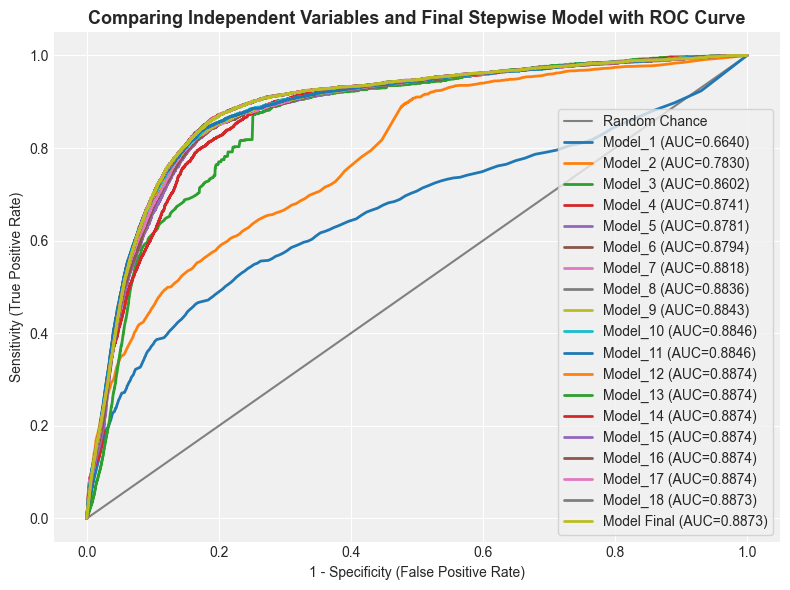

AUC values:
Model_1: 0.6640
Model_2: 0.7830
Model_3: 0.8602
Model_4: 0.8741
Model_5: 0.8781
Model_6: 0.8794
Model_7: 0.8818
Model_8: 0.8836
Model_9: 0.8843
Model_10: 0.8846
Model_11: 0.8846
Model_12: 0.8874
Model_13: 0.8874
Model_14: 0.8874
Model_15: 0.8874
Model_16: 0.8874
Model_17: 0.8874
Model_18: 0.8873
Model Final: 0.8873


In [44]:
# 計算 included 長度
n_vars = len(included)
print(f"共有 {n_vars} 個變數可供建模")

# 建立模型與 scaler 的容器
models = []
scalers = []
model_names = []
included_var_sets = []

# 自動迴圈建立模型
for k in range(1, n_vars + 1):
    model_info = sklearn_logit_with_k(
        train_df, test_df, dep_var="is_fraud", included=included, k=k
    )
    _, _, _, model, scaler = model_info
    
    models.append(model)
    scalers.append(scaler)
    included_var_sets.append(included[:k])
    model_names.append(f"Model_{k}")

# 最後一個完整模型 (Final Model)
model_final_info = sklearn_logit_with_k(
    train_df, test_df, dep_var="is_fraud", included=included, k=314657018
)
_, _, _, model_final, scaler_final = model_final_info

models.append(model_final)
scalers.append(scaler_final)
included_var_sets.append(included)
model_names.append("Model Final")

print(f"總共建立 {len(models)} 個模型（含最終模型）")

# 🔹 繪製多模型 ROC 比較圖
plot_multiple_roc_sklearn(
    models=models,
    scalers=scalers,
    model_names=model_names,
    test_df=test_df,
    included_var_sets=included_var_sets,
    target_col="is_fraud"
)

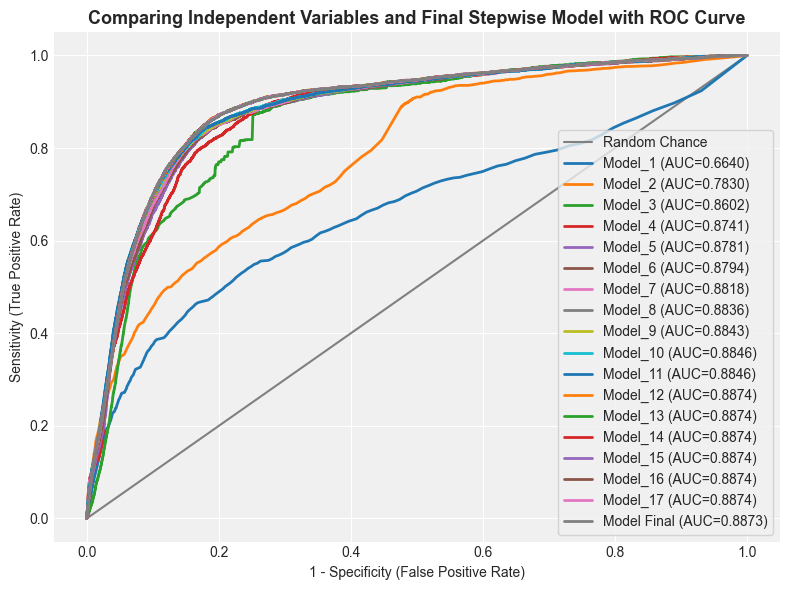

AUC values:
Model_1: 0.6640
Model_2: 0.7830
Model_3: 0.8602
Model_4: 0.8741
Model_5: 0.8781
Model_6: 0.8794
Model_7: 0.8818
Model_8: 0.8836
Model_9: 0.8843
Model_10: 0.8846
Model_11: 0.8846
Model_12: 0.8874
Model_13: 0.8874
Model_14: 0.8874
Model_15: 0.8874
Model_16: 0.8874
Model_17: 0.8874
Model Final: 0.8873


In [45]:
# 移除重複模型（例如 Model_21）
duplicate_index = model_names.index("Model_18")
del models[duplicate_index]
del scalers[duplicate_index]
del included_var_sets[duplicate_index]
del model_names[duplicate_index]

# 🔹 繪製多模型 ROC 比較圖
plot_multiple_roc_sklearn(
    models=models,
    scalers=scalers,
    model_names=model_names,
    test_df=test_df,
    included_var_sets=included_var_sets,
    target_col="is_fraud"
)



In [47]:
from sklearn.metrics import f1_score

# 1️⃣ 取出測試資料中模型用到的欄位
X_test = test_df[included].astype(float)

# 2️⃣ 使用訓練時的 scaler 標準化
X_test_scaled = scaler.transform(X_test)

# 3️⃣ 取出真實標籤
y_test = test_df["is_fraud"].astype(int)

# 4️⃣ 模型預測機率與自訂 cutoff
y_prob =  skmodel.predict_proba(X_test_scaled)[:, 1]
y_pred_custom = (y_prob >= 0.48).astype(int)

# 5️⃣ 計算 F1-score
f1 = f1_score(y_test, y_pred_custom)

print("F1 Score (cutoff=0.48):", round(f1, 4))

F1 Score (cutoff=0.48): 0.0125
